In [1]:
!pip install torch
!pip install torchvision
!pip install kaggle
!pip install matplotlib
!pip install spacy
!pip install pandas
# English tokenizer data
!spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 15.7 MB/s eta 0:00:00
  Created wheel for kaggle: filename=kaggle-1.6.14-py3-none-any.whl size=105124 sha256=49dc309b07ddcb59a35433b740aa777ab28192aa9ea620767c96b8a4bc212595
  Stored in directory: /root/.cache/pip/wheels/ec/d9/04/93be57edf3835182a8e76d8ff87f7e77a0113f473ba3721ee0
Successfully built kaggle
  Attempting uninstall: certifi
    Found existing installation: certifi 2020.6.20
    Uninstalling certifi-2020.6.20:
      Successfully uninstalled certifi-2020.6.20
2024-05-19 19:23:31.823870: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-19 19:23:31.824010: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attemptin

In [2]:
# Used for model
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Used to format data
import torchvision
import torchvision.transforms as transforms
# Used to show results
import matplotlib.pyplot as plt

# Used to download data
import os
#import kaggle
import zipfile
from pathlib import Path

# Additional file imports
from image_captioning_from_scratch import CNNtoRNN
from dataset import Flickr8kDataset
from dataset import Collate

# Used to convert test images
from PIL import Image

2024-05-19 19:23:46.514492: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-19 19:23:46.514562: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-19 19:23:46.516088: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-19 19:23:46.524196: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-19 19:23:47.431568: W tensorflow/compiler/tf2

In [3]:
# Displays an image with its respective caption
def displayImage(img, caption):
    plt.figure()
    plt.imshow(img.permute(1,2,0))
    plt.title(caption)
    plt.axis("off")

In [4]:
# Data transformations
transform = transforms.Compose(
    [
        transforms.Resize((512,512)),
        #transforms.RandomHorizontalFlip(p=0.5),
        #transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
# Load dataset
dataset_path = "./dataset/"
root = os.path.join(dataset_path, 'Images')
annotations = os.path.join(dataset_path, 'captions.txt')
freq_threshold = 4
dataset = Flickr8kDataset(root, annotations, transform, freq_threshold)

# Get device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load trained model
test_model = torch.load("./models/Model3|Layers:1:80").to(device)

# Test image transforms
test_transform = transforms.Compose(
    [
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)



In [5]:
# Get numerical index of padding
pad_idx = dataset.vocab.stoi["<PAD>"]
dataloader = DataLoader(
    dataset,
    batch_size = 8,
    num_workers = 2,
    shuffle = True,
    collate_fn=Collate(pad_idx)
    )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


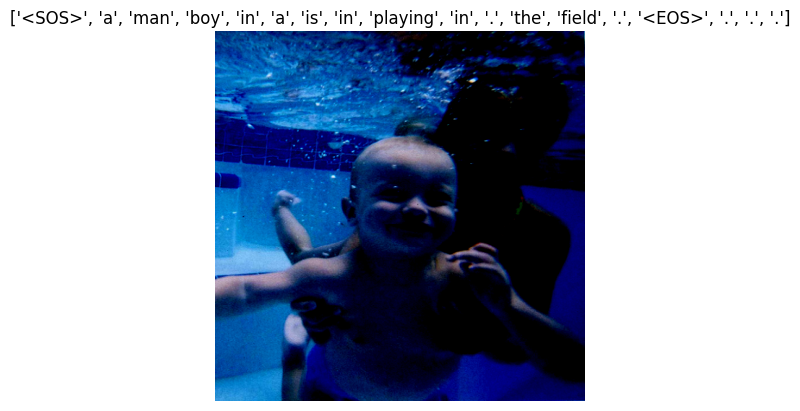

In [14]:
j = 1
test_model.eval()
with torch.inference_mode():
    for i, (images, captions) in enumerate(dataloader):
        # Get batch of images and captions
        images, captions = images.to(device), captions.to(device)
        # Make predictions 
        preds = test_model(images, captions[:-1])
        
        preds = torch.argmax(preds, 2)
        
        # Creates caption of image 'j'
        pred_caption = []
        for i in range(preds.shape[0]):
            pred_caption.append(dataset.vocab.itos[preds[i,j].item()])
        # Display image with predicted caption
        displayImage(images[j].cpu(),pred_caption)
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 1, 256])


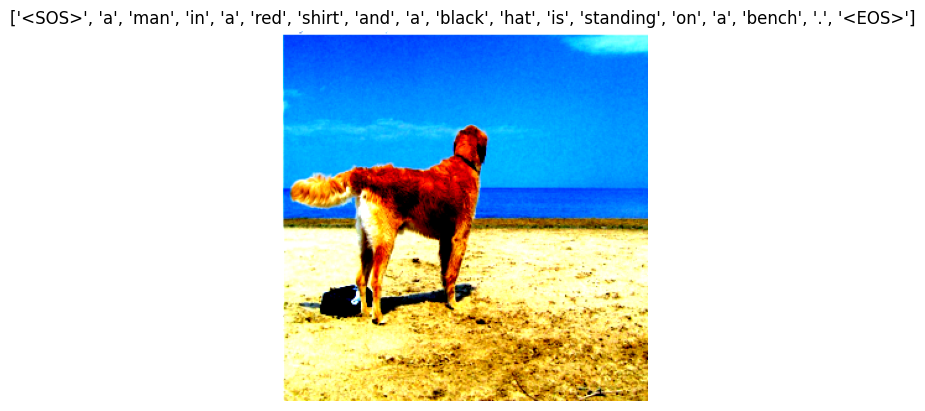

In [7]:
# Turn evaluation mode on
test_model.eval()

# Test Image 1
test_image1 = test_transform(Image.open("test_examples/dog.jpg").convert("RGB")).unsqueeze(0)

# Predictions
caption = test_model.caption_image(test_image1.to(device), dataset.vocab)

displayImage(test_image1.squeeze(0), caption)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 1, 256])


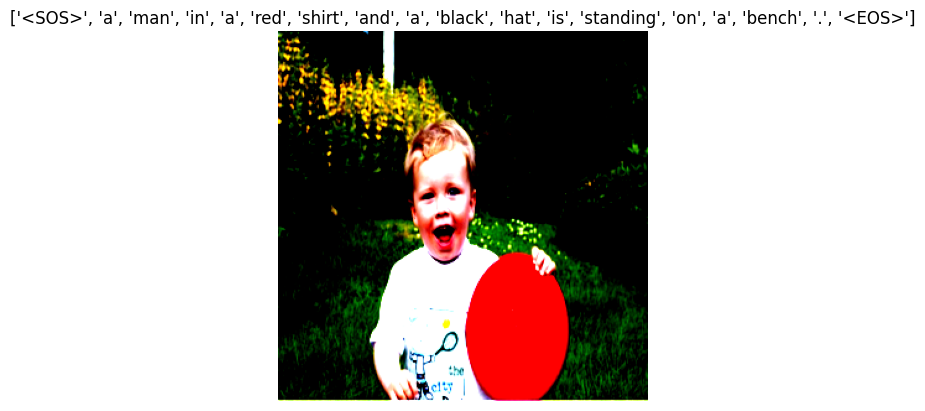

In [8]:
# Test Images 2
test_image2 = test_transform(Image.open("test_examples/child.jpg").convert("RGB")).unsqueeze(0)

caption = test_model.caption_image(test_image2.to(device), dataset.vocab)

displayImage(test_image2.squeeze(0), caption)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 1, 256])


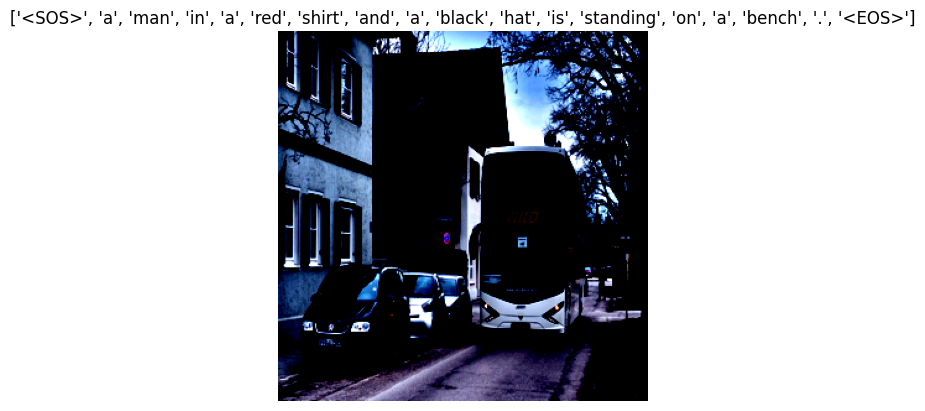

In [9]:
# Test Image 3
test_image3 = test_transform(Image.open("test_examples/bus.png").convert("RGB")).unsqueeze(0)

caption = test_model.caption_image(test_image3.to(device), dataset.vocab)

displayImage(test_image3.squeeze(0), caption)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 1, 256])


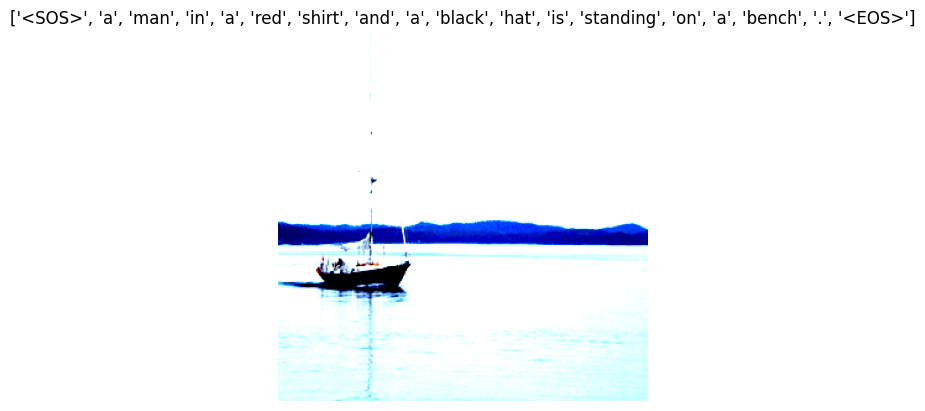

In [10]:
# Test Image 4
test_image4 = test_transform(Image.open("test_examples/boat.png").convert("RGB")).unsqueeze(0)

caption = test_model.caption_image(test_image4.to(device), dataset.vocab)

displayImage(test_image4.squeeze(0), caption)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 1, 256])


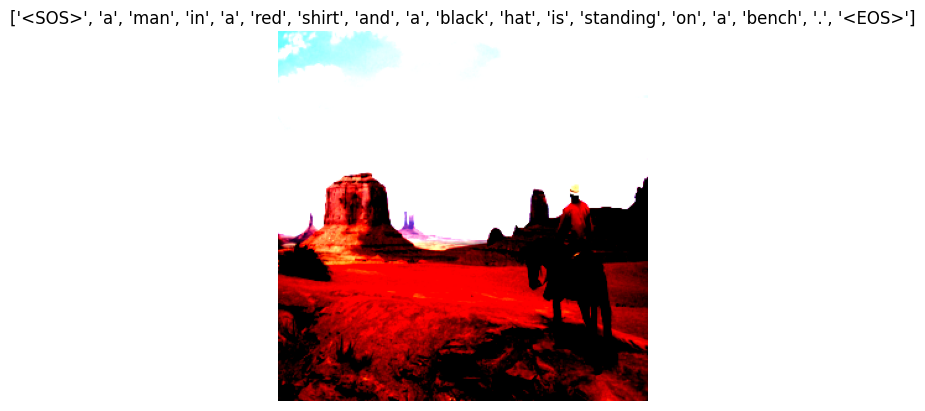

In [11]:
# Test Image 5
test_image5 = test_transform(Image.open("test_examples/horse.png").convert("RGB")).unsqueeze(0)

caption = test_model.caption_image(test_image5.to(device), dataset.vocab)

displayImage(test_image5.squeeze(0), caption)